In [1]:
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

import pyxspec_bb as pxb
#import pyxspec_helpers as ph

import os
import pickle
import pathlib
import importlib
import numpy as np

path_to_spec = '/Users/jmdunca2/do-dem/spectroscopy/'

We will take a list of DEM results, and examine for which cases we have already doen spectroscopy (and how). We will evaluate existing results, and decide how to proceed. 

In [2]:
with open('/Users/jmdunca2/do-dem/reference_files/result_file_dict_postghost_postshut.pickle', 'rb') as f:
    dictz = pickle.load(f)


filelist_ = dictz['all regions']['quiet files']
filelist_.sort()

Spectroscopy options:


- Models: isothermal, two-thermal, isothermal+nonthermal
- Gain correction: yes vs. no
- Pile-up fit component: yes vs. no

We want all three model fits to finish for all cases (ideally). We do NOT want to include the gain correction (as it's not according to the prescribed method to do it automatically like this without identifying the Fe complex). We DO want to include a pile-up component, and we want to evalauate its magnitude to see when it seems concerning. 



Given the above, we want the following fits to finish for each:
- Isothermal, no gain, yes pileup
- Two-thermal, no gain, yes pileup
- Isothermal+Non-thermal, no gain, yes pileup


We will make a new set of categories:
- Cases where spectroscopy is finished
- Cases where spectroscopy must be revisited
- Cases where we have not yet done spectroscopy

In [3]:
nonspec_files = []
specfiles = []
for f in filelist_:
    the_path = pathlib.Path('/'.join(f.split('/')[0:-1])+'/')

    #Make an xspec out directory in the data directory if one does not already exist.
    out_path = the_path / 'xspec_out/'
    if out_path.exists():
        #print(out_path)
        #out_path.mkdir()
        specfiles.append(f)
        
    else:
        #print('none')
        nonspec_files.append(f)

print('No spectroscopy yet: ', len(nonspec_files))
print('Spectroscopy done: ', len(specfiles))
print('')

print('For those with prior spectroscopy...')
importlib.reload(pxb)
all_finishes, nonefiles, incompletes, fullsets, nopileup = pxb.check_rez_pyxspec(specfiles, shush=True)
print('All Fits Complete: ', len(fullsets))
print('Some Fits Complete: ', len(incompletes))
print('No Fits Complete: ', len(nonefiles))
print('Insufficient Pile-up for fit, all finished without: ', len(nopileup))
print(len(fullsets)+len(incompletes)+len(nonefiles))


No spectroscopy yet:  0
Spectroscopy done:  278

For those with prior spectroscopy...
All Fits Complete:  237
Some Fits Complete:  28
No Fits Complete:  13
Insufficient Pile-up for fit, all finished without:  13
278


In [4]:
# todo_specfiles = incompletes #nonspec_files + incompletes + nonefiles
# print('Files to do (or re-do): ', len(todo_specfiles))

Now, we need to get ready for spectroscopy (make directories and apply grppha to PHA files, and make scripts to run spectral fits for each case.

In [4]:
#This makes spectroscopy dictionaries, grouped PHA files (min 10 counts/bin), 
#and SRM files (response format required for XSPEC)
importlib.reload(pxb)
pxb.prep_for_spec(nonspec_files, out_dir_name='xspec_out/')


/Users/jmdunca2/do-dem/spectroscopy
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_11dec14/18-38-55_18-47-05
nu20001005001A06_0_4_p_sr.pha nu20001005001A06_0_4_p_sr_grp.pha A_0_4_grppha.log
nu20001005001A06_21_24_p_sr.pha nu20001005001A06_21_24_p_sr_grp.pha A_21_24_grppha.log
nu20001005001B06_0_4_p_sr.pha nu20001005001B06_0_4_p_sr_grp.pha B_0_4_grppha.log
nu20001005001B06_21_24_p_sr.pha nu20001005001B06_21_24_p_sr_grp.pha B_21_24_grppha.log
/Users/jmdunca2/do-dem/spectroscopy

/Users/jmdunca2/do-dem/spectroscopy
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/14-56-55_15-14-20
nu80413201001A06_0_4_p_sr.pha nu80413201001A06_0_4_p_sr_grp.pha A_0_4_grppha.log
nu80413201001A06_21_24_p_sr.pha nu80413201001A06_21_24_p_sr_grp.pha A_21_24_grppha.log
nu80413201001B06_0_4_p_sr.pha nu80413201001B06_0_4_p_sr_grp.pha B_0_4_grppha.log
nu80413201001B06_21_24_p_sr.pha nu80413201001B06_21_24_p_sr_grp.pha B_21_24_grppha.log
/Users/jmdunca2/do-dem/spectroscopy

/Users/jmdunca2/do-dem/spectroscopy
/

Now, we need to make scripts with which to run spectroscopy for all the intervals.

This makes scripts for each fit, and a wrapper which runs all three as subprocesses (to add a time limit, currently 10 min) for each time interval. It then makes a big script that calls all these wrappers in batches of five at a time ("run_quiet_spectra.sh"). 

In [5]:
#Make sure we're in the location of the template files, etc.
print(os.getcwd())
os.chdir(path_to_spec)

#Make the scripts
importlib.reload(pxb)
pxb.make_pyxspec_subprocess_scripts(nonspec_files, xspec_dir_str='xspec_out',
                                    plot=True)

/Users/jmdunca2/do-dem/spectroscopy
#!/bin/sh



python /Users/jmdunca2/do-dem/DEM_folders/initial_dem_11dec14/18-38-55_18-47-05/xspec_out/subrun_pyxspec.py >  /Users/jmdunca2/do-dem/DEM_folders/initial_dem_11dec14/18-38-55_18-47-05/xspec_out/pyxspec_out.txt &
python /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/14-56-55_15-14-20/xspec_out/subrun_pyxspec.py >  /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/14-56-55_15-14-20/xspec_out/pyxspec_out.txt &
python /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/15-14-20_15-56-35/xspec_out/subrun_pyxspec.py >  /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/15-14-20_15-56-35/xspec_out/pyxspec_out.txt &
python /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/16-57-00_17-33-15/xspec_out/subrun_pyxspec.py >  /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/16-57-00_17-33-15/xspec_out/pyxspec_out.txt &
python /Users/jmdunca2/do-dem/DEM_folders/initial_dem_7sep18/18-10-15_18-27-45/xspec_out/subrun_pyxspec.py > 

For cases that did finish, we want to find a good way to look at the amount of pileup. Are there cases where the amount of pileup is great enough that we lose confidence in our DEM pileup correction ([grades 0-4] - 1.25*[grades 21-24])?

In [4]:
f_ = fullsets[60]
print(f_)
importlib.reload(pxb)
pxb.save_SPEX_params(specfiles, '_nogain', pileup=True, clobber=True)
pxb.save_SPEX_params(specfiles, '_nogain_nm_re_the_pileup', pileup=False, clobber=True)

with open(f_, 'rb') as f:
    data = pickle.load(f)

print(data['SPEX_dict'].keys())
print('')

print('Pile Up Params - Isothermal')
print('Lambda A ', data['SPEX_dict']['lam_puA_it'][0])
print('Mu A     ', data['SPEX_dict']['mu_puA_it'][0])
print('Sigma A  ', data['SPEX_dict']['sigma_puA_it'][0])
print('Norm A   ', data['SPEX_dict']['norm_puA_it'][0])
print('')
print('Lambda B ', data['SPEX_dict']['lam_puB_it'][0])
print('Mu B     ', data['SPEX_dict']['mu_puB_it'][0])
print('Sigma B  ', data['SPEX_dict']['sigma_puB_it'][0])
print('Norm B   ', data['SPEX_dict']['norm_puB_it'][0])
print('')

print('Pile Up Params - Two Thermal')
print('Lambda A ', data['SPEX_dict']['lam_puA_tt'][0])
print('Mu A     ', data['SPEX_dict']['mu_puA_tt'][0])
print('Sigma A  ', data['SPEX_dict']['sigma_puA_tt'][0])
print('Norm A   ', data['SPEX_dict']['norm_puA_tt'][0])
print('')

print('Lambda B ', data['SPEX_dict']['lam_puB_tt'][0])
print('Mu B     ', data['SPEX_dict']['mu_puB_tt'][0])
print('Sigma B  ', data['SPEX_dict']['sigma_puB_tt'][0])
print('Norm B   ', data['SPEX_dict']['norm_puB_tt'][0])
print('')


print('Pile Up Params - Isothermal + Non-thermal')
print('Lambda A ', data['SPEX_dict']['lam_puA_nt'][0])
print('Mu A     ', data['SPEX_dict']['mu_puA_nt'][0])
print('Sigma A  ', data['SPEX_dict']['sigma_puA_nt'][0])
print('Norm A   ', data['SPEX_dict']['norm_puA_nt'][0])
print('')

print('Lambda B ', data['SPEX_dict']['lam_puB_nt'][0])
print('Mu B     ', data['SPEX_dict']['mu_puB_nt'][0])
print('Sigma B  ', data['SPEX_dict']['sigma_puB_nt'][0])
print('Norm B   ', data['SPEX_dict']['norm_puB_nt'][0])
print('')

/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//21-41-05_21-42-15/21-41-05_21-42-15_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle
dict_keys(['kT_m_it', 'norm_m_it', 'lam_puA_it', 'mu_puA_it', 'sigma_puA_it', 'norm_puA_it', 'factor_m_it', 'lam_puB_it', 'mu_puB_it', 'sigma_puB_it', 'norm_puB_it', 'CSTAT_FPMA_it', 'CSTAT_FPMB_it', 'kT_m_tt', 'norm_m_tt', 'kT_2_m_tt', 'norm_2_m_tt', 'lam_puA_tt', 'mu_puA_tt', 'sigma_puA_tt', 'norm_puA_tt', 'factor_m_tt', 'lam_puB_tt', 'mu_puB_tt', 'sigma_puB_tt', 'norm_puB_tt', 'CSTAT_FPMA_tt', 'CSTAT_FPMB_tt', 'kT_m_nt', 'norm_m_nt', 'BreakE_m_nt', 'PhoIndx2_m_nt', 'norm_2_m_nt', 'lam_puA_nt', 'mu_puA_nt', 'sigma_puA_nt', 'norm_puA_nt', 'factor_m_nt', 'lam_puB_nt', 'mu_puB_nt', 'sigma_puB_nt', 'norm_puB_nt', 'CSTAT_FPMA_nt', 'CSTAT_FPMB_nt'])

Pile Up Params - Isothermal
Lambda A  4.987560042609046 ct / keV
Mu A      2.699130990632661 keV
Sigma A   1.1805514558172643 keV
Norm A    0.1317420031591934

Lambda B  1.4506117205860543 ct / keV
Mu B

all regions
01-nov-14_1 region_0
01-nov-14_1 region_1
01-nov-14_2 region_0
11-dec-14 region_0
19-feb-16 region_0
22-apr-16_1 region_0
22-apr-16_2 region_0
26-jul-16_1 region_0
26-jul-16_1 region_1
27-jul-16_1 region_0
27-jul-16_1 region_1
26-jul-16_2 region_0
10-oct-17 region_0
30.011268126458482 MK 6.98880032541119 MK
10-oct-17 region_1
29-may-18_1 region_0
30.006358257593973 MK 4.044491789158612 MK
29-may-18_2 region_0
29-may-18_2 region_1
07-sep-18 region_0
09-sep-18 region_0
10-sep-18 region_0
12-apr-19 region_0
30.011637889894196 MK 3.762412647095529 MK
30.011637931034482 MK 3.8163624766042172 MK
30.011637931034482 MK 3.7264308110691613 MK
30.011444357171385 MK 4.06580515117075 MK
30.0115538347021 MK 4.1569337867646405 MK
30.004927798960242 MK 4.712083886677974 MK
30.000251547251825 MK 3.995294273270269 MK
30.008981083088894 MK 3.9317931783422493 MK
30.00879089386984 MK 3.8844912911390472 MK
13-apr-19 region_0
4.2620379472534875 MK 30.00841201442673 MK
30.011294669858668 MK 4.3277

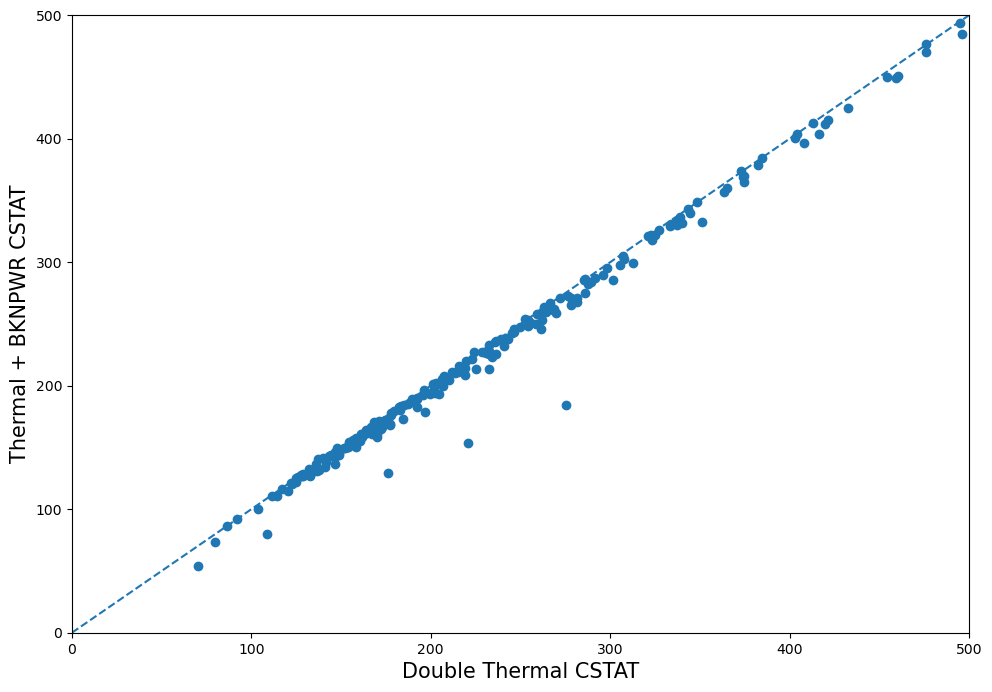

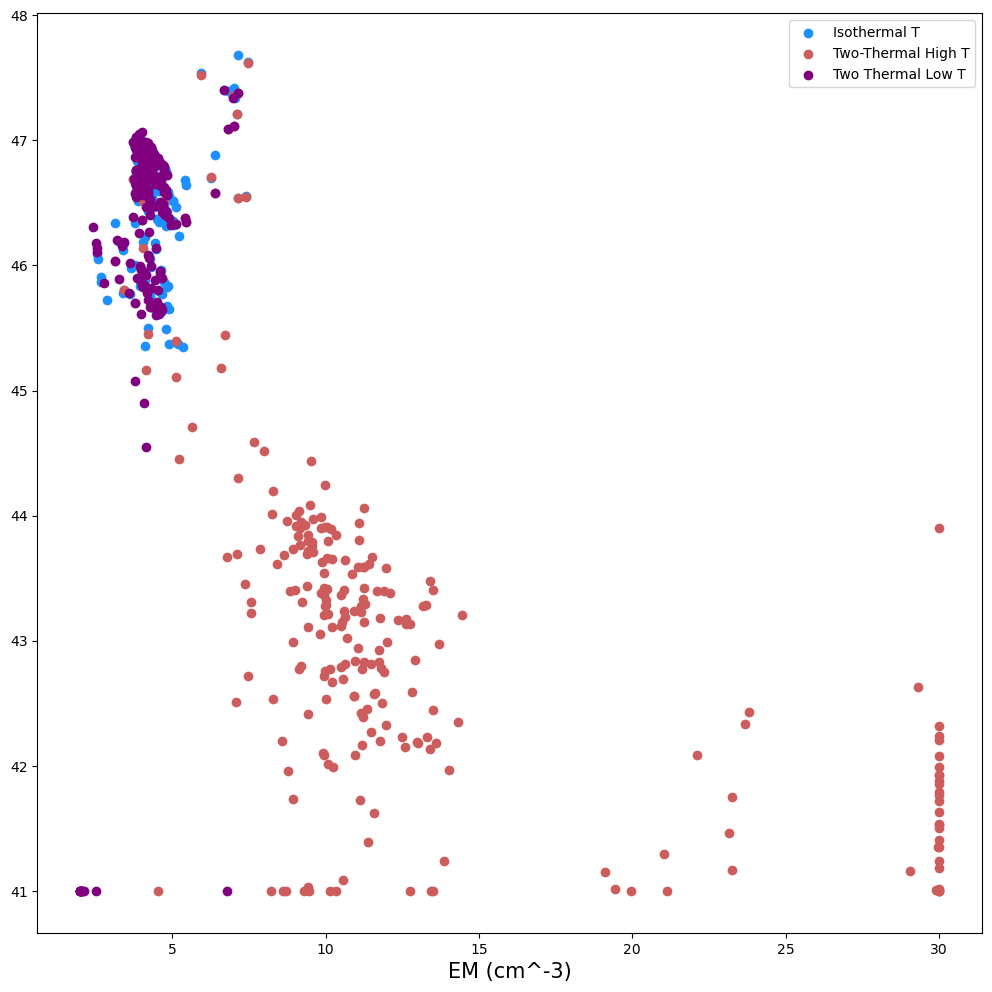

In [14]:
from matplotlib import pyplot as plt
from astropy import units as u

kt_its_ = []
em_its_ = []

kt1_tts_ = []
em1_tts_ = []
kt2_tts_ = []
em2_tts_ = []

breake_ = []
out_of_bounds = []
pho2_ = []


statz = []
thermal_better = []
nonthermal_better = []
missing_some = []
high_T_lim=[]
for k in dictz.keys():
    print(k)
    if k != 'all regions':
        
        kt_its = []
        em_its = []
        
        kt1_tts = []
        em1_tts = []
        kt2_tts = []
        em2_tts = []

        breake = []
        pho2 = []

        files = dictz[k]['quiet files all-inst']
        for f_ in files:
            with open(f_, 'rb') as f:
                data = pickle.load(f)

            #print(data['SPEX_dict'].keys())

            try:
                threestats = np.array([data['SPEX_dict']['CSTAT_FPMA_it']+data['SPEX_dict']['CSTAT_FPMB_it'],
                              data['SPEX_dict']['CSTAT_FPMA_tt']+data['SPEX_dict']['CSTAT_FPMB_tt'],
                              data['SPEX_dict']['CSTAT_FPMA_nt']+data['SPEX_dict']['CSTAT_FPMB_nt']])
                #if np.max(threestats) > 500:
                #    print(threestats)
                #    print(f_)
                #    print('')
                statz.append(threestats)

                BE = data['SPEX_dict']['BreakE_m_nt'][0]
                breake.append(BE)
                if BE.value > 20 or BE.value < 4:
                    out_of_bounds.append(f_)
                pho2.append(data['SPEX_dict']['PhoIndx2_m_nt'][0])


                kt_its.append(data['SPEX_dict']['kT_m_it'][0])
                em_its.append(data['SPEX_dict']['norm_m_it'][0])

                if data['SPEX_dict']['kT_m_tt'][0] > data['SPEX_dict']['kT_2_m_tt'][0]:
                    kt1_tts.append(data['SPEX_dict']['kT_m_tt'][0])  
                    em1_tts.append(data['SPEX_dict']['norm_m_tt'][0])
                    kt2_tts.append(data['SPEX_dict']['kT_2_m_tt'][0])
                    em2_tts.append(data['SPEX_dict']['norm_2_m_tt'][0])
                else:
                    kt1_tts.append(data['SPEX_dict']['kT_2_m_tt'][0])
                    em1_tts.append(data['SPEX_dict']['norm_2_m_tt'][0])
                    kt2_tts.append(data['SPEX_dict']['kT_m_tt'][0])
                    em2_tts.append(data['SPEX_dict']['norm_m_tt'][0])
                
                if (data['SPEX_dict']['kT_m_tt'][0] > 30.0*u.MK) or (data['SPEX_dict']['kT_2_m_tt'][0] > 30.0*u.MK):
                    print(data['SPEX_dict']['kT_m_tt'][0], data['SPEX_dict']['kT_2_m_tt'][0])
                    high_T_lim.append(f_)
            
            except KeyError:
                pass

            try:
                if data['SPEX_dict']['CSTAT_FPMA_tt']+data['SPEX_dict']['CSTAT_FPMB_tt'] < data['SPEX_dict']['CSTAT_FPMA_nt']+data['SPEX_dict']['CSTAT_FPMB_nt']:
                    thermal_better.append(f_)
                else:
                    nonthermal_better.append(f_)
            except KeyError:
                missing_some.append(f_)

        kt_its_.extend(kt_its)
        em_its_.extend(em_its)
        
        kt1_tts_.extend(kt1_tts)
        em1_tts_.extend(em1_tts)
        kt2_tts_.extend(kt2_tts)
        em2_tts_.extend(em2_tts)

        breake_.extend(breake)
        pho2_.extend(pho2)

            #print('')

statz = np.array(statz)

labf=15

fig = plt.figure(figsize=(10, 7), tight_layout = {'pad': 1})
plt.scatter(statz[:,1], statz[:,2])
plt.plot([0,5000],[0, 5000], linestyle='dashed')
plt.xlim([0,500])
plt.ylim([0,500])
plt.xlabel('Double Thermal CSTAT', fontsize=labf)
plt.ylabel('Thermal + BKNPWR CSTAT', fontsize=labf)
plt.savefig('CSTAT_comp.png', dpi=300)




templists = [kt_its_, kt1_tts_, kt2_tts_]
for i in range(0, len(templists)):
    templists[i] = np.array([kt.value for kt in templists[i]]) #*u.MK
    
emlists = [em_its_, em1_tts_, em2_tts_]
for i in range(0, len(emlists)):
    emlists[i] = np.array([np.log10(em.value) for em in emlists[i]]) #*(1/u.cm**3)


breake = np.array([b.value for b in breake_]) #*(1/u.cm**3)

pho2 = np.array([p.value for p in pho2_]) #



labels = ['Isothermal T', 'Two-Thermal High T', 'Two Thermal Low T']
colors = ['dodgerblue', 'indianred', 'purple']

fig = plt.figure(figsize=(10, 10), tight_layout = {'pad': 1})
for i in range(0, len(templists)):
    plt.scatter(templists[i], emlists[i], label=labels[i], color=colors[i])
    
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('T (MK)', fontsize=labf)
plt.xlabel('EM (cm^-3)', fontsize=labf)
plt.legend()
plt.savefig('thermal_T_vs_EM.png', dpi=300)
#plt.ylim([1e38,1e48])


In [15]:
high_T_lim

['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//01-40-15_01-41-15/01-40-15_01-41-15_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_29may18_1//19-17-05_19-19-00/19-17-05_19-19-00_5.6_7.2_29-may-18_1_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-27-50_15-30-45/15-27-50_15-30-45_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-30-45_15-32-30/15-30-45_15-32-30_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-32-30_15-36-15/15-32-30_15-36-15_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//17-10-45_17-11-25/17-10-45_17-11-25_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//17-37-25_17-38-05/17-37-25_17-38-05_5.6_7.2_12

2.224427178110489e+45
1e+41
2.364000694231609e+45
(array([], dtype=int64),)


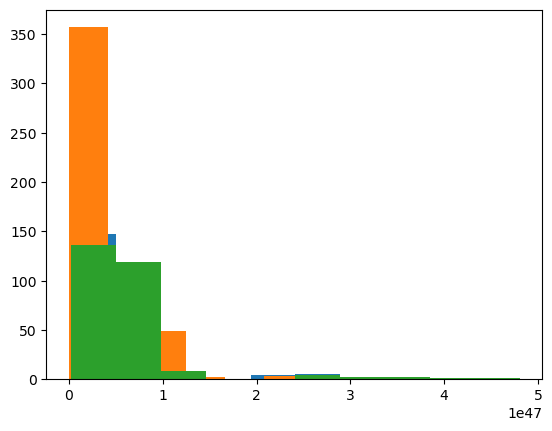

In [9]:
bad_em=[]

it_ems=[]
tt_ems=[]
nt_ems=[]
for f_ in specfiles:
    #print(f_)
    highT=False
    
    with open(f_, 'rb') as f:
        data = pickle.load(f)

    spec = data['SPEX_dict']

    it_ems.append(spec['norm_m_it'][0])
    if 'norm_m_tt' in list(spec.keys()):
        tt_ems.append(spec['norm_m_tt'][0])
        if spec['norm_m_tt'][0].value < 1e41:
            #print(f_)
            bad_em.append(f_)
    if 'norm_2_m_tt' in list(spec.keys()):
        tt_ems.append(spec['norm_2_m_tt'][0])
        #print(spec['norm_2_m_tt'][0].value, type(spec['norm_2_m_tt'][0].value)) #f_)
        if spec['norm_2_m_tt'][0].value < 1e41:
            #print(f_)
            bad_em.append(f_)

    if 'norm_m_nt' in list(spec.keys()):
        nt_ems.append(spec['norm_m_nt'][0])

from matplotlib import pyplot as plt
plt.hist(it_ems)
plt.hist(tt_ems)
plt.hist(nt_ems)
#plt.xscale('log')

print(np.min([it.value for it in it_ems]))
print(np.min([tt.value for tt in tt_ems]))
print(np.min([nt.value for nt in nt_ems]))

print(np.where(np.array([tt.value for tt in tt_ems]) < 1e41))



Evauluating intervals - we will sort them thus. 


NO CONCERNS:

thermal_best
–All fits finish, no temperatures are pegged at upper limit, tt fit CSTAT is less than nt fit CSTAT

thermal_only
–Only thermal fits finish, no temperatures are pegged at upper limit

iso_better
–it + nt fits finish, no temperatures are pegged at upper limit, it CSTAT better 

thermal_only_one_plaus
-Only thermal fits finish, only one fit has temperatures pegged at upper limit (i.e. a plausible thermal fit remains)


CONCERNS, now resolved:

thermal_only_bad
–Only thermal fits finish, one or more temperatures are pegged at upper limit (NONE)

CONCERNS, REMAINING:

thermal_plaus
–All fits finish, no temperatures are pegged at upper limit, any CSTAT relationship (EXAMINE THESE)

nt_over_iso
–Only it and nt fits finish, nt CSTAT lower (EXAMINE THESE)

thermal_issues:
–All fits finish, some temperatures are pegged at upper limit (EXAMINE THESE)

iso_only 
–Only isothermal fit finishes (EXAMINE THESE)
    –If they are faint/high livetime/little pile-up, fine. If not. examine further. 

In [18]:
#CSTAT RATIO AT WHICH WE SAY ISOTHERMAL IS BETTER (DUE TO FAR FEWER PARAMS)
it_to_nt=0.8
tt_to_nt=0.95


thermal_best=[]
thermal_only=[]
thermal_only_bad=[]
thermal_plaus=[]
iso_better=[]
iso_similar=[]
nt_over_iso=[]
thermal_issues=[]
iso_only=[]
thermal_only_one_plaus=[]
others=[]



#for f_ in specfiles:
for f_ in high_T_lim:
    #print(f_)
    highT=False
    
    with open(f_, 'rb') as f:
        data = pickle.load(f)

    spec = data['SPEX_dict']

    finishes=np.zeros(3)
    
    if 'kT_m_it' in list(spec.keys()):
        finishes[0] = 1
        it_stat = spec['CSTAT_FPMA_it']+spec['CSTAT_FPMB_it']
        if spec['kT_m_it'][0].value > 30:
            highT = True
            
    if 'kT_m_tt' in list(spec.keys()):
        finishes[1] = 1
        tt_stat = spec['CSTAT_FPMA_tt']+spec['CSTAT_FPMB_tt']
        if spec['kT_m_tt'][0].value > 30:
            highT = True
            #print(highT)
    if 'kT_m_tt_2' in list(spec.keys()):
        if spec['kT_m_tt_2'][0].value > 30:
            highT = True
            #print(highT)
    if 'kT_m_nt' in list(spec.keys()):
        finishes[2] = 1  
        nt_stat = spec['CSTAT_FPMA_nt']+spec['CSTAT_FPMB_nt']


    #If all three fits finish, and none hit the upper temperature limit:
    if np.sum(finishes) == 3 and highT == False:
        #If the non-thermal fit is worse than at least one thermal option
        if nt_stat > tt_to_nt*tt_stat:
            thermal_best.append(f_)
            continue
        elif nt_stat > it_to_nt*it_stat:
            thermal_best.append(f_)
            continue
        else:
            thermal_plaus.append(f_)
            continue

    #If all three fits finish, and at least one hits the upper temperature limit:
    if np.sum(finishes) == 3 and highT == True:
        if (nt_stat > it_to_nt*it_stat) and (spec['kT_m_it'][0].value < 30):
            thermal_best.append(f_)
            continue
        else:
            thermal_issues.append(f_)
            continue
    
    if np.sum(finishes) == 1 and 'kT_m_it' in list(spec.keys()):
        iso_only.append(f_)
        continue

    if np.sum(finishes) == 2:
        if 'kT_m_tt' in list(spec.keys()):
            if highT==False:
                thermal_only.append(f_)
                continue
            elif (spec['kT_m_tt'][0].value < 30) or (spec['kT_m_it'][0].value < 30):
                thermal_only_one_plaus.append(f_)
                continue
                
        elif 'kT_m_nt' in list(spec.keys()):
            if nt_stat > it_to_nt*it_stat:
                if not highT:
                    iso_better.append(f_)
                    continue

            elif nt_stat > 0.8*it_stat:
                if not highT:
                    iso_similar.append(f_)
                    continue
                
            else:
                nt_over_iso.append(f_)
                continue
        else:
            print('WHat the HECK')

    others.append(f_)
        

print('No concerns cases...')
print('thermal_best: ', len(thermal_best))
print('thermal_only: ', len(thermal_only))
print('iso_better: ', len(iso_better))
print('iso_similar: ', len(iso_similar))
print('thermal_only_one_plaus: ', len(thermal_only_one_plaus), thermal_only_one_plaus)
print('total: ', len(thermal_best)+len(thermal_only)+len(iso_better)+len(iso_similar))
print('')     
print('Potential concerns cases...')
print('thermal_only_bad: ', len(thermal_only_bad))
print('thermal_plaus: ', len(thermal_plaus))
print('nt_over_iso: ', len(nt_over_iso))
print('thermal_issues: ', len(thermal_issues), thermal_issues)
print('iso_only: ', len(iso_only))
print('total: ',  len(iso_only)+len(thermal_issues)+len(nt_over_iso)+len(thermal_plaus)+len(thermal_only_bad))
print('')
print('Others: ', len(others))

no_concerns = thermal_best + thermal_only + iso_better + iso_similar + thermal_only_one_plaus
concerns = thermal_only_bad+thermal_plaus+nt_over_iso+thermal_issues+iso_only
temp_extend = nt_over_iso+thermal_issues+iso_only

No concerns cases...
thermal_best:  22
thermal_only:  0
iso_better:  0
iso_similar:  0
thermal_only_one_plaus:  0 []
total:  22

Potential concerns cases...
thermal_only_bad:  0
thermal_plaus:  0
nt_over_iso:  0
thermal_issues:  0 []
iso_only:  0
total:  0

Others:  0


potential to be improved due to addition of double-thermal fit (or improvement)
nt_over_iso, thermal_issues, iso_only

In [11]:
iso_only


['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//03-21-15_04-04-45/03-21-15_04-04-45_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//04-41-50_05-09-15/04-41-50_05-09-15_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_20nov21/region_0//01-50-30_02-00-35/01-50-30_02-00-35_5.6_7.2_20-nov-21_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_27jul16/region_0//00-18-50_00-23-00/00-18-50_00-23-00_5.6_7.2_27-jul-16_1_MC_DEM_result_withparams.pickle']

In [6]:
sep_fine = [c for c in no_concerns if '6sep22' in c]
print(len(sep_fine))
sep_fine

3


['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-33-10_19-33-40/19-33-10_19-33-40_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-34-10_19-34-40/19-34-10_19-34-40_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-33-40_19-34-10/19-33-40_19-34-10_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle']

In [7]:
sep_concerns = [c for c in concerns if '6sep22' in c]
other_concerns= [c for c in concerns if '6sep22' not in c]

print(len(concerns))
print(len(sep_concerns))
print(len(other_concerns))
other_concerns

12
4
8


['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_14jan21/region_0//14-34-35_15-25-05/14-34-35_15-25-05_5.6_7.2_14-jan-21_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//03-21-15_04-04-45/03-21-15_04-04-45_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//04-41-50_05-09-15/04-41-50_05-09-15_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10oct17/region_0//05-09-15_05-41-25/05-09-15_05-41-25_5.6_7.2_10-oct-17_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_20nov21/region_0//01-50-30_02-00-35/01-50-30_02-00-35_5.6_7.2_20-nov-21_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_27jul16/region_0//00-13-00_00-18-50/00-13-00_00-18-50_5.6_7.2_27-jul-16_1_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_27jul16/regi

In [64]:
# def check_pileup(file):
#     import nustar_dem_prep as nu
#     import numpy as np
#     importlib.reload(nu)
    
#     working_dir = str(pathlib.Path('/'.join(f_.split('/')[0:-2])+'/'))+'/'
#     timestring = f_.split('/')[-2]
#     #print(working_dir, timestring)
#     engs, cnts, cnts_u = nu.plot_grade_spectra(working_dir, timestring, 'A', return_spec=True)
#     #print(engs[np.where(cnts_u*1.25 > cnts)])

#     #print(engs[110], engs[210])
#     c6 = np.sum(cnts[110:210])
#     c6_u = np.sum(cnts_u[110:210])
#     #print(c6_u/c6)

#     if c6_u/c6 > 0.2:
#         print(working_dir, timestring)
#         print(c6_u/c6)
        
    
#     print('')


# for f_ in incompletes:
#     check_pileup(f_)

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10oct17/region_0/ 01-28-30_01-35-55
0.4375



/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10oct17/region_0/ 03-21-15_04-04-45
0.32075471698113206

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10oct17/region_0/ 04-41-50_05-09-15
0.23333333333333334

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10oct17/region_0/ 05-09-15_05-41-25
0.3888888888888889






/Users/jmdunca2/do-dem/DEM_folders/initial_dem_12apr19/ 18-48-10_18-48-40
0.3333333333333333


/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19/ 03-09-25_03-10-55
0.5

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19/ 03-10-55_03-11-50
0.38461538461538464

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19/ 03-22-00_03-24-15
0.9285714285714286

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19/ 08-57-15_08-57-45
0.42857142857142855

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19/ 09-04-25_09-05-35
0.5

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_13apr19

27 July 16 intervals of concern: all of these have quite different FPMA/B spectra (factor is at 0.5-0.6). All fits are poor, any non-thermal that finish have their break energies pegged at 4 keV

14 Jan 21 interval of concern: spectrum largely falls off by ~5 keV, but individual counts at higher energies create very hard tail when re-grouped. All fits struggle with excess, non-thermal most sucessfully (two-thermal higher temp hits limit)

10 oct 17 intervals of concern: only isothermal finishes, but with lots of structure in the residuals. fair amount of pile up.

20 nov 21 interval of concern: only isothermal finishes, but with lots of structure in the residuals. not much pile up. 

29 may 18 2 interval of concern: factor is at 1.3, all fits are poor, non-thermal fit break energy pegged at 4 keV.

/Users/jmdunca2/do-dem/spectroscopy


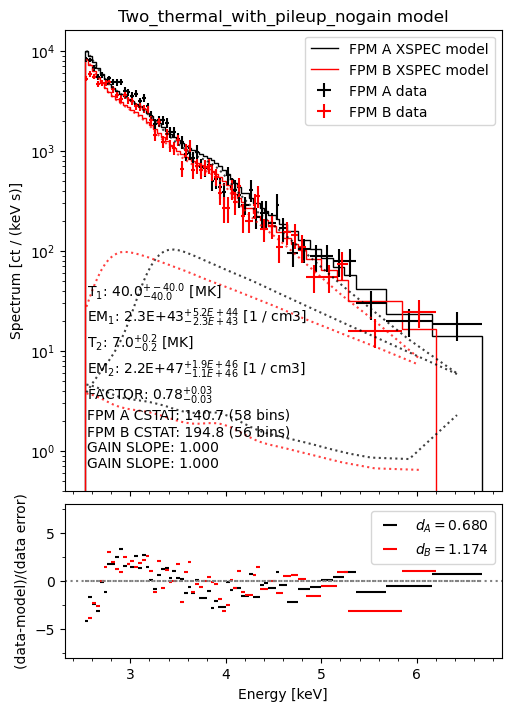

In [38]:
# os.chdir(path_to_spec)

# f_ = thermal_best[0]

# import xspec
# #Path to top-level do-dem directory - edit for your system.
# path_to_spec = '/Users/jmdunca2/do-dem/spectroscopy/'
# from sys import path as sys_path
# sys_path.append(path_to_spec+'/pyxspec_extension/')

# from pyxspec_extension.interface import XSPECInterface
# from pyxspec_extension.plotter import ModelPlotter
# from pyxspec_extension.config import DEFAULT_PARAMETER_FILE, DEFAULT_PILEUP_PARAMETER_FILE


# abundance_file = '/Users/jmdunca2/do-dem/reference_files/feld92a_coronal0.txt'

# pha_path = pathlib.Path('/'.join(f_.split('/')[0:-1]))
# out_path = pathlib.Path('/'.join(f_.split('/')[0:-1])+'/xspec_out/')

# print(pha_path)
# print(out_path)

# #Save the current path to return later.
# current_path = os.getcwd()
# print(current_path)

# #Go to the data directory.
# os.chdir(pha_path)
# print(os.getcwd())

# #====================================================================
# #XSPEC time!
# #====================================================================

# xspec.Xset.abund = f'file {abundance_file}'
# interface = XSPECInterface()

# # fpmA_pha = 'nu80310229001A06_0_4_p_sr_grp.pha'
# # fpmA_pileup = 'nu80310229001A06_21_24_p_sr_grp.pha'
# # fpmB_pha = 'nu80310229001B06_0_4_p_sr_grp.pha'
# # fpmB_pileup = 'nu80310229001B06_21_24_p_sr_grp.pha'

# obsid='90311211001'
# fpmA_pha = 'nu'+obsid+'A06_0_4_p_sr_grp.pha'
# fpmA_pileup = 'nu'+obsid+'A06_21_24_p_sr_grp.pha'
# fpmB_pha = 'nu'+obsid+'B06_0_4_p_sr_grp.pha'
# fpmB_pileup = 'nu'+obsid+'B06_21_24_p_sr_grp.pha'



# interface.add_instrument(
#     name = 'FPM A',
#     signal_file = fpmA_pha,
#     pileup_file = fpmA_pileup)
# interface.add_instrument(
#     name = 'FPM B',
#     signal_file = fpmB_pha,
#     pileup_file = fpmB_pileup)

# interface.read_data(pha_path)
# xspec.AllData.ignore('bad') 
# xspec.AllData.ignore('**-2.5 15.0-**')  # Specify which energy channels to ignore.


# expression='const*(vapec+vapec)'
# model_name = 'two_thermal_with_pileup_nogain'



# pileup_models = interface.set_pileup_model('expmodgauss')
# model = interface.add_component(
#     model_name = model_name,
#     expression = expression,
#     parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
#     out_dir = out_path)

# if expression=='const*vapec' or expression=='const*(vapec+vapec)':
#     par1 = model.vapec.kT
#     #new upper limit in MK /11.6
#     newtop=40/11.6
#     par1.values = par1.values[0:4]+[newtop, newtop]

# if expression=='const*(vapec+vapec)':
#     par1 = model.vapec_4.kT
#     #new upper limit in MK /11.6
#     newtop=40/11.6
#     par1.values = par1.values[0:4]+[newtop, newtop]

# # Modify the pileup norm to accurately represent the grade 0-4 pileup (1.25x).
# for instrument, pileup_model in zip(interface.instruments, pileup_models):
#         pileup_component = pileup_model.componentNames[0]
#         signal_model = interface.instruments[instrument].get_signal_model(
#             model_name)
#         pileup_model_name = interface.instruments[instrument].pileup_model_name
#         signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
#             f'{pileup_model_name}:p4'
#         signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
#             f'{pileup_model_name}:p4'




# slopes = {
#     'FPM A': (1, 0.01, 0.94, 0.94, 1.0, 1.0), # Follows XSPEC's convention: (initial, delta, hard min, soft min, soft max, hard max)
#     'FPM B': (1, 0.01, 0.94, 0.94, 1.0, 1.0)
# }
# offsets = {'A': 0, 'B': 0}
# interface.set_gain(
#     slopes = slopes, offsets = offsets,
#     fit_slope = False, fit_offset = False)

# interface.fit(
#     num_iterations = 1000,
#     critical_delta = 0.01,
#     fit_statistic = 'cstat',
#     fit_error = True # XSPEC will determine the error on all unfrozen parameters
# )

# interface.archive_previous()
# interface.archive.save(out_path / f'{model_name}_archive.pkl')

# archive = interface.archive

# from matplotlib import pyplot as plt

# fig, axs = plt.subplots(
#     2, 1, figsize=(5,7),
#     sharex=True, layout='constrained',
#     gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

# plotter = ModelPlotter(archive)
# ax0, ax1 = plotter.make_xspec_plot(model_name, axs=axs)
# ax1.axhline(0, color='gray', ls=':')
# ax0.legend()
# ax1.legend()
# plt.savefig(out_path / f'{model_name}.png')



# os.chdir(current_path)
# print(os.getcwd())

In [32]:
model.vapec.kT

In [31]:
dir(model)
comp1 = model.vapec

newtop=40/11.6
print(newtop)
par1 = comp1.kT
# Follows XSPEC's convention: (initial, delta, hard min, soft min, soft max, hard max)
print(par1.values)
temp_lims = [p*11.6 for p in par1.values]
print(temp_lims)#= [2, 0.1, 0, 0, 15, 15]
par1.values = par1.values[0:4]+[newtop, newtop]
par1.values

3.4482758620689657
[0.25862068965517243, 0.0025862068965517245, 0.1724137931034483, 0.1724137931034483, 2.586206896551724, 2.586206896551724]


[0.25862068965517243,
 0.0025862068965517245,
 0.1724137931034483,
 0.1724137931034483,
 3.4482758620689657,
 3.4482758620689657]

In [137]:
#Setting up paths for the example case

#pha_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_11sep17/16-04-40_16-05-10/')
#out_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_11sep17/16-04-40_16-05-10/xspec_out/')
pha_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_11sep17/16-04-10_16-04-40/')
out_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_11sep17/16-04-10_16-04-40/xspec_out/')

#pha_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_12sep17/region_0/21-11-00_21-11-30/') #21-11-00_21-11-30_5.6_7.2_12-sep-17_MC_DEM_result_withparams.pickle'
#out_path = pathlib.Path('/Users/jmdunca2/do-dem/initial_dem_12sep17/region_0/21-11-00_21-11-30/xspec_out/')

#Make an xspec out directory in the data directory if one does not already exist.
if not out_path.exists():
    out_path.mkdir()

#Save the current path to return later.
current_path = os.getcwd()
print(current_path)

#Go to the data directory.
os.chdir(pha_path)
print(os.getcwd())


#====================================================================
#XSPEC time!
#====================================================================

xspec.Xset.abund = f'file {abundance_file}'
interface = XSPECInterface()

# fpmA_pha = 'nu80310229001A06_0_4_p_sr_grp.pha'
# fpmA_pileup = 'nu80310229001A06_21_24_p_sr_grp.pha'
# fpmB_pha = 'nu80310229001B06_0_4_p_sr_grp.pha'
# fpmB_pileup = 'nu80310229001B06_21_24_p_sr_grp.pha'

fpmA_pha = 'nu80310211001A06_0_4_p_sr_grp.pha'
fpmA_pileup = 'nu80310211001A06_21_24_p_sr_grp.pha'
fpmB_pha = 'nu80310211001B06_0_4_p_sr_grp.pha'
fpmB_pileup = 'nu80310211001B06_21_24_p_sr_grp.pha'


interface.add_instrument(
    name = 'FPM A',
    signal_file = fpmA_pha,
    pileup_file = fpmA_pileup)
interface.add_instrument(
    name = 'FPM B',
    signal_file = fpmB_pha,
    pileup_file = fpmB_pileup)

interface.read_data(pha_path)
xspec.AllData.ignore('bad') 
xspec.AllData.ignore('**-2.5 15.0-**')  # Specify which energy channels to ignore.

# model_name = 'isothermal'
# model = interface.add_component(
#     model_name = model_name,
#     expression = 'const*vapec',
#     parameter_limits_file = DEFAULT_PARAMETER_FILE,
#     out_dir = out_path)

expression='const*vapec'
model_name = 'isothermal_with_pileup'

pileup_models = interface.set_pileup_model('expmodgauss')
model = interface.add_component(
    model_name = model_name,
    expression = expression,
    parameter_limits_file = DEFAULT_PILEUP_PARAMETER_FILE,
    out_dir = out_path)

if expression=='const*(vapec+bknpower)':
    print('')
    print('LOOK HERE')
    comp2 = model.bknpower
    par1 = comp2.PhoIndx1
    par1.values = 2
    par1.frozen = True

    par2 = comp2.BreakE
    par2.values = 6

    par3 = comp2.PhoIndx2
    par3.values = [2, 0.1, 0, 0, 15, 15]


# Modify the pileup norm to accurately represent the grade 0-4 pileup (1.25x).
for instrument, pileup_model in zip(interface.instruments, pileup_models):
        pileup_component = pileup_model.componentNames[0]
        signal_model = interface.instruments[instrument].get_signal_model(
            model_name)
        pileup_model_name = interface.instruments[instrument].pileup_model_name
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'
        signal_model.__dict__[pileup_component].norm.link = '1.25 * ' \
            f'{pileup_model_name}:p4'




slopes = {
    'FPM A': (1, 0.01, 0.94, 0.94, 1.0, 1.0), # Follows XSPEC's convention: (initial, delta, hard min, soft min, soft max, hard max)
    'FPM B': (1, 0.01, 0.94, 0.94, 1.0, 1.0)
}
offsets = {'A': 0, 'B': 0}
interface.set_gain(
    slopes = slopes, offsets = offsets,
    fit_slope = True, fit_offset = False)

interface.fit(
    num_iterations = 1000,
    critical_delta = 0.01,
    fit_statistic = 'cstat',
    fit_error = True # XSPEC will determine the error on all unfrozen parameters
)

interface.archive_previous()
interface.archive.save(out_path / f'{model_name}_archive.pkl')

archive = interface.archive

fig, axs = plt.subplots(
    2, 1, figsize=(5,7),
    sharex=True, layout='constrained',
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

plotter = ModelPlotter(archive)
ax0, ax1 = plotter.make_xspec_plot(model_name, axs=axs)
ax1.axhline(0, color='gray', ls=':')
ax0.legend()
ax1.legend()
plt.savefig(out_path / f'{model_name}.png')



os.chdir(current_path)
print(os.getcwd())

['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//17-51-15_17-51-45/17-51-15_17-51-45_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//17-54-45_17-55-15/17-54-45_17-55-15_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-32-10_19-32-40/19-32-10_19-32-40_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-32-40_19-33-10/19-32-40_19-33-10_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-34-40_19-35-10/19-34-40_19-35-10_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//19-35-40_19-36-10/19-35-40_19-36-10_5.6_7.2_06-sep-22_MC_DEM_result_withparams.pickle']

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_9dec22/east/ 23-41-45_23-43-00


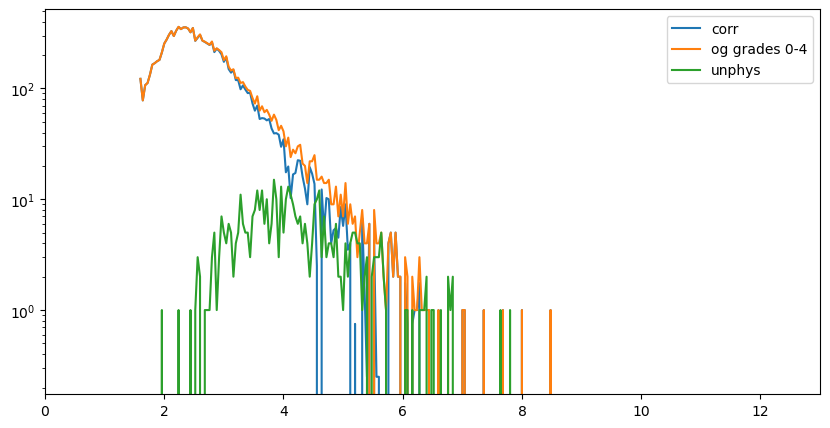

In [110]:
f_ = iso_only[10]
import nustar_dem_prep as nu
import numpy as np
working_dir = str(pathlib.Path('/'.join(f_.split('/')[0:-2])+'/'))+'/'
timestring = f_.split('/')[-2]
print(working_dir, timestring)
nu.plot_grade_spectra(working_dir, timestring, 'A', return_spec=False)

In [99]:
engs #, 
cnts 
cnts_u
#, cnts_u

print(engs[np.where(cnts_u > cnts)])

#grades 0-4 represent a total of five combinations, while grades 21-24 represent 4. Thus, the accurate comparison by area is 1.25*unphysical

print(engs[np.where(cnts_u*1.25 > cnts)])

[4.92 6.44]
[4.92 5.08 5.28 5.32 5.4  5.64 5.68 6.08 6.44]


In [90]:
fullsets

['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10sep18//14-29-10_14-49-40/14-29-10_14-49-40_5.6_7.2_10-sep-18_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10sep18//15-26-40_15-43-45/15-26-40_15-43-45_5.6_7.2_10-sep-18_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_10sep18//15-43-45_16-10-40/15-43-45_16-10-40_5.6_7.2_10-sep-18_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-12-55_15-16-05/15-12-55_15-16-05_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-18-55_15-22-50/15-18-55_15-22-50_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-22-50_15-25-40/15-22-50_15-25-40_5.6_7.2_12-apr-19_MC_DEM_result_withparams.pickle',
 '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_12apr19//15-25-40_15-27-50/15-25-40_15-27-50_5.6_7.2_12-apr-19_MC_DE

In the present parameterization this corresponds to having loc and scale equal to mu and sigma, and scale parameter equal to K = 1/(sigma*lambda).

exponnorm.pdf(x, K, loc, scale)

The PDF in terms of the parameterization used in the fits is as follows:

F(x) = λ/2 EXP[ λ/2 (2µ + λσ^2 - 2x)] ERFC[ (µ+λσ^2 - x)/(2^(1/2)σ)]

Which means that x has units of keV, as expected (and the PDF as a whole has units of counts*keV.

0.9020312125962571 1 / ct 2.939511910777824 keV 0.6114121820996266 keV


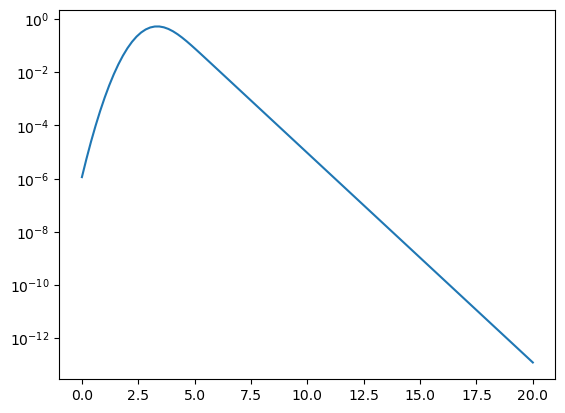

In [70]:
from scipy.stats import exponnorm
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u 

sig = data['SPEX_dict']['sigma_puA_it'][0]
lam = data['SPEX_dict']['lam_puA_it'][0]
mu = data['SPEX_dict']['mu_puA_it'][0]


K = 1/(sig*lam)
loc = mu
scale = sig

print(K, loc, scale)

x = np.linspace(0, 20, 100)*u.keV
enorm = exponnorm.pdf(x, K, loc, scale)

plt.plot(x, enorm)
plt.yscale('log')
#plt.xscale('log')

In [71]:
enorm 

array([1.13880856e-06, 5.57544253e-06, 2.45460832e-05, 9.72074729e-05,
       3.46413566e-04, 1.11137050e-03, 3.21156310e-03, 8.36439211e-03,
       1.96485821e-02, 4.16668199e-02, 7.98503341e-02, 1.38470885e-01,
       2.17638060e-01, 3.10650828e-01, 4.03693354e-01, 4.79097024e-01,
       5.21291427e-01, 5.22559536e-01, 4.85515002e-01, 4.21171047e-01,
       3.44079240e-01, 2.67336876e-01, 1.99624012e-01, 1.44755865e-01,
       1.02898497e-01, 7.22496808e-02, 5.03833258e-02, 3.50150718e-02,
       2.42976565e-02, 1.68505085e-02, 1.16834124e-02, 8.10023307e-03,
       5.61587228e-03, 3.89345268e-03, 2.69930603e-03, 1.87141135e-03,
       1.29743729e-03, 8.99504815e-04, 6.23620822e-04, 4.32352248e-04,
       2.99746994e-04, 2.07812636e-04, 1.44075145e-04, 9.98863585e-05,
       6.92505609e-05, 4.80109622e-05, 3.32856870e-05, 2.30767497e-05,
       1.59989600e-05, 1.10919747e-05, 7.68999369e-06, 5.33142247e-06,
       3.69624043e-06, 2.56257938e-06, 1.77661957e-06, 1.23171876e-06,
      

In [13]:
#Look at spec plots (cases with plots can be assumed to have finished)
# import glob
# for f in specfiles:

#     thepath = pathlib.Path('/'.join(f.split('/')[0:-1])+'/')
#     #timestring = pxb.path_timestring(thepath)
#     pngs = glob.glob(str(thepath)+'/xspec_out/*.png')
#     for p in pngs:
#         print(p)
#     print(len(pngs))
#     print('')

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/two_thermal_with_pileup.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/isothermal_with_pileup_nogain.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/thermal_nonthermal_with_pileup_nogain.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/isothermal_with_pileup.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/two_thermal_with_pileup_nogain.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/14-29-10_14-49-40/xspec_out/thermal_nonthermal_with_pileup.png
6

/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/15-26-40_15-43-45/xspec_out/two_thermal_with_pileup.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/15-26-40_15-43-45/xspec_out/isothermal_with_pileup_nogain.png
/Users/jmdunca2/do-dem/DEM_folders/initial_dem_10sep18/15-26-40_15-43-